<a href="https://colab.research.google.com/github/emerson-matos/tcc-notebooks/blob/main/sentimentos/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
!nvidia-smi

Fri Sep 15 06:47:26 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     Off | 00000000:08:00.0  On |                  N/A |
|  0%   44C    P3              29W / 285W |   1090MiB / 12282MiB |     38%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [2]:
date = '2023-09-01'
filename = 'analisar.csv'
dados = pd.read_csv(f"/content/gdrive/MyDrive/tcc/exploratoria/{date}-{filename}")

dados.head()[['text', 'source', 'data_avaliacao']]

,text,source,data_avaliacao
0,"Lugar fantástico, recomendo super.",hotel-marsol-beach-resort,2023-07-06
1,Tudo perfeito,hotel-marsol-beach-resort,2023-07-06
2,excelente!,hotel-marsol-beach-resort,2023-07-06
3,Belo lugar.,hotel-marsol-beach-resort,2023-07-06
4,Ótimo local,hotel-marsol-beach-resort,2023-07-06


In [3]:
treinado = pd.read_csv(f"/content/gdrive/MyDrive/tcc/testando-classificacao.csv")

treinado.head()[['text', 'source', 'data_avaliacao']]

,text,source,data_avaliacao
0,"Lugar fantástico, recomendo super.",analisar,2023-07-06
1,Tudo perfeito,analisar,2023-07-06
2,excelente!,analisar,2023-07-06
3,Belo lugar.,analisar,2023-07-06
4,Ótimo local,analisar,2023-07-06


In [4]:
dados.describe()

,rating,likes,mes_avaliacao,ano_avaliacao
count,49219.000000,49219.000000,49219.000000,49219.000000
mean,4.604787,0.166623,6.790650,2020.699181
std,0.895289,0.731727,1.524495,1.746374
min,1.000000,0.000000,1.000000,2018.000000
25%,5.000000,0.000000,7.000000,2019.000000
50%,5.000000,0.000000,7.000000,2021.000000
75%,5.000000,0.000000,7.000000,2022.000000
max,5.000000,25.000000,12.000000,2023.000000


# 08

In [5]:
!pip install transformers[sentencepiece] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 69.1 MB/s eta 0:00:00


## bert pre treinado

In [6]:
sentences = [
  'Foi muito bom, exceto o primeiro atendimento na recepção na chegada, fizemos o chek-in e não nos informaram onde ficaria o nosso chalé, tivemos que ficar perguntando a alguns funcionários, fora isso tudo de bom.',
  'Lindo d mais',
  'Muito bom. Vale o valor pago',
  'Tudo perfeito.',
  'Drinks muito bom',
  'Incrível',
  'Foi ótimo dias maravilhosos...',
  'Passagem incrível.  Boa comida.  Piscinas amplas com águas mornas.',
  'Alimentação péssima! Do mais tudo ok!',
  'Muito sofisticado',
  'Otima',
  'Lugar fantástico, recomendo super.',
  'Estou deslumbrado com a beleza ,ao entorno do hotel ,quarto amplo e confortável ,a piscina espetacular ,foi uma experiência incrível!!!'
]

In [7]:
import torch
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForSequenceClassification  # Or BertForPreTraining for loading pretraining heads
from transformers import pipeline


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

teste = dados.copy()

teste.head(5)

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,data_avaliacao,mes_avaliacao,ano_avaliacao,mes_ano_avaliacao,com_texto,nao_vazio,traduzido,depois_2017,analisar
0,2023-07-07 00:33:49.096786,5.0,10 horas atrás,0,False,"Lugar fantástico, recomendo super.",hotel-marsol-beach-resort,9,2023-07-06,7,2023,2023-07,True,True,False,True,True
1,2023-07-07 00:33:49.185915,5.0,10 horas atrás,0,True,Tudo perfeito,hotel-marsol-beach-resort,36,2023-07-06,7,2023,2023-07,True,True,False,True,True
2,2023-07-07 00:33:50.064473,5.0,11 horas atrás,0,True,excelente!,hotel-marsol-beach-resort,52,2023-07-06,7,2023,2023-07,True,True,False,True,True
3,2023-07-07 00:33:50.080896,5.0,11 horas atrás,0,True,Belo lugar.,hotel-marsol-beach-resort,41,2023-07-06,7,2023,2023-07,True,True,False,True,True
4,2023-07-07 00:33:50.109826,5.0,11 horas atrás,0,False,Ótimo local,hotel-marsol-beach-resort,7,2023-07-06,7,2023,2023-07,True,True,False,True,True


In [33]:
PRE_TRAINED_MODEL_NAME_1 = 'philschmid/distilbert-base-multilingual-cased-sentiment'

tokenizer1 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_1, do_lower_case=False)
model1 = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME_1).to(device)
classifier1 = pipeline('sentiment-analysis',
                      model=model1,
                      tokenizer=tokenizer1,
                      max_length=512,
                      truncation=True,
                      pad_to_max_length=True,
                      device=device,
                      framework="pt",
                      batch_size=16,
)

In [18]:
classifier(sentences)

[{'label': 'negative', 'score': 0.9226691722869873},
 {'label': 'neutral', 'score': 0.4194216728210449},
 {'label': 'negative', 'score': 0.8745064735412598},
 {'label': 'positive', 'score': 0.9755363464355469},
 {'label': 'negative', 'score': 0.7377951145172119},
 {'label': 'negative', 'score': 0.5013454556465149},
 {'label': 'negative', 'score': 0.4844314754009247},
 {'label': 'neutral', 'score': 0.5337896943092346},
 {'label': 'negative', 'score': 0.9250680804252625},
 {'label': 'neutral', 'score': 0.42814022302627563},
 {'label': 'positive', 'score': 0.8648582696914673},
 {'label': 'positive', 'score': 0.9849022030830383},
 {'label': 'positive', 'score': 0.9673092365264893}]

In [15]:
PRE_TRAINED_MODEL_NAME_2 = 'lxyuan/distilbert-base-multilingual-cased-sentiments-student'

tokenizer2 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_2, do_lower_case=False)
model2 = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME_2).to(device)
classifier2 = pipeline('sentiment-analysis',
                      model=model2,
                      tokenizer=tokenizer2,
                      max_length=512,
                      truncation=True,
                      pad_to_max_length=True,
                      device=device,
                      framework="pt",
                      batch_size=16,
)

In [16]:
classifier2(sentences)

[{'label': 'negative', 'score': 0.5495229959487915},
 {'label': 'positive', 'score': 0.5910864472389221},
 {'label': 'positive', 'score': 0.8239201903343201},
 {'label': 'negative', 'score': 0.7108703851699829},
 {'label': 'positive', 'score': 0.5783613920211792},
 {'label': 'positive', 'score': 0.533176600933075},
 {'label': 'positive', 'score': 0.9308533072471619},
 {'label': 'positive', 'score': 0.7248801589012146},
 {'label': 'positive', 'score': 0.7259961366653442},
 {'label': 'negative', 'score': 0.5079984664916992},
 {'label': 'positive', 'score': 0.5399190783500671},
 {'label': 'positive', 'score': 0.9592684507369995},
 {'label': 'negative', 'score': 0.7474359273910522}]

In [13]:
PRE_TRAINED_MODEL_NAME_3 = 'citizenlab/twitter-xlm-roberta-base-sentiment-finetunned'

tokenizer3 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_3, do_lower_case=False)
model3 = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME_3).to(device)
classifier3 = pipeline('sentiment-analysis',
                      model=model3,
                      tokenizer=tokenizer3,
                      max_length=512,
                      truncation=True,
                      pad_to_max_length=True,
                      device=device,
                      framework="pt",
                      batch_size=16,
)

In [14]:
classifier3(sentences)

[{'label': 'Positive', 'score': 0.9781147837638855},
 {'label': 'Positive', 'score': 0.9915336966514587},
 {'label': 'Positive', 'score': 0.9922174215316772},
 {'label': 'Positive', 'score': 0.9926760792732239},
 {'label': 'Positive', 'score': 0.9896873831748962},
 {'label': 'Positive', 'score': 0.9074751734733582},
 {'label': 'Positive', 'score': 0.9909008741378784},
 {'label': 'Positive', 'score': 0.9921296238899231},
 {'label': 'Negative', 'score': 0.9787968397140503},
 {'label': 'Negative', 'score': 0.9137847423553467},
 {'label': 'Positive', 'score': 0.9924835562705994},
 {'label': 'Positive', 'score': 0.9925462603569031},
 {'label': 'Positive', 'score': 0.99159836769104}]

In [11]:
PRE_TRAINED_MODEL_NAME_4 = 'cardiffnlp/twitter-xlm-roberta-base-sentiment'

tokenizer4 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_4, do_lower_case=False)
model4 = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME_4).to(device)
classifier4 = pipeline('sentiment-analysis',
                      model=model4,
                      tokenizer=tokenizer4,
                      max_length=512,
                      truncation=True,
                      pad_to_max_length=True,
                      device=device,
                      framework="pt",
                      batch_size=16,
)

In [12]:
classifier4(sentences)

[{'label': 'positive', 'score': 0.5777750015258789},
 {'label': 'positive', 'score': 0.8819499611854553},
 {'label': 'positive', 'score': 0.9002392888069153},
 {'label': 'positive', 'score': 0.8959977030754089},
 {'label': 'positive', 'score': 0.8850589990615845},
 {'label': 'positive', 'score': 0.695933997631073},
 {'label': 'positive', 'score': 0.9281375408172607},
 {'label': 'positive', 'score': 0.9304505586624146},
 {'label': 'negative', 'score': 0.9328173398971558},
 {'label': 'negative', 'score': 0.4048030972480774},
 {'label': 'positive', 'score': 0.6601681113243103},
 {'label': 'positive', 'score': 0.9392898678779602},
 {'label': 'positive', 'score': 0.9188212156295776}]

In [9]:
PRE_TRAINED_MODEL_NAME_5 = 'ramonmedeiro1/bertimbau-products-reviews-pt-br'

tokenizer5 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_5, do_lower_case=False)
model5 = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME_5).to(device)
classifier5 = pipeline('sentiment-analysis',
                      model=model5,
                      tokenizer=tokenizer5,
                      max_length=512,
                      truncation=True,
                      pad_to_max_length=True,
                      device=device,
                      framework="pt",
                      batch_size=16,
)

In [10]:
classifier5(sentences)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


[{'label': 'Positivo', 'score': 0.5946270823478699},
 {'label': 'Muito Positivo', 'score': 0.9520754218101501},
 {'label': 'Positivo', 'score': 0.5735266208648682},
 {'label': 'Muito Positivo', 'score': 0.8601934313774109},
 {'label': 'Positivo', 'score': 0.5460475087165833},
 {'label': 'Muito Positivo', 'score': 0.9668323993682861},
 {'label': 'Muito Positivo', 'score': 0.8012335896492004},
 {'label': 'Muito Positivo', 'score': 0.9259946942329407},
 {'label': 'Negativo', 'score': 0.6605251431465149},
 {'label': 'Muito Positivo', 'score': 0.8711700439453125},
 {'label': 'Muito Positivo', 'score': 0.4971369802951813},
 {'label': 'Muito Positivo', 'score': 0.936265766620636},
 {'label': 'Muito Positivo', 'score': 0.9635603427886963}]

In [19]:
treinado.head()

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,data_avaliacao,mes_avaliacao,ano_avaliacao,mes_ano_avaliacao,com_texto,nao_vazio,traduzido,depois_2017,analisar,text_truncado,sentiment_bert
0,2023-07-07 00:33:49.096786,5.0,10 horas atrás,0,False,"Lugar fantástico, recomendo super.",analisar,9,2023-07-06,7,2023,2023-07,True,True,False,True,True,"Lugar fantástico, recomendo super.",positive
1,2023-07-07 00:33:49.185915,5.0,10 horas atrás,0,True,Tudo perfeito,analisar,36,2023-07-06,7,2023,2023-07,True,True,False,True,True,Tudo perfeito,negative
2,2023-07-07 00:33:50.064473,5.0,11 horas atrás,0,True,excelente!,analisar,52,2023-07-06,7,2023,2023-07,True,True,False,True,True,excelente!,positive
3,2023-07-07 00:33:50.080896,5.0,11 horas atrás,0,True,Belo lugar.,analisar,41,2023-07-06,7,2023,2023-07,True,True,False,True,True,Belo lugar.,positive
4,2023-07-07 00:33:50.109826,5.0,11 horas atrás,0,False,Ótimo local,analisar,7,2023-07-06,7,2023,2023-07,True,True,False,True,True,Ótimo local,positive


In [20]:
from datasets import Dataset
dataset = Dataset.from_pandas(teste)

In [32]:
dataset = dataset.map(lambda x: {"sentiment_bert_1": classifier1(x['text']),
                                 "sentiment_bert_2": classifier2(x['text']),
                                 "sentiment_bert_3": classifier3(x['text']),
                                 "sentiment_bert_4": classifier3(x['text']),
                                 "sentiment_bert_5": classifier3(x['text'])}, batched=True)

Map:   0%|          | 0/49219 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [35]:
dataset[0]

{'retrieval_date': '2023-07-07 00:33:49.096786',
 'rating': 5.0,
 'relative_date': '10 horas atrás',
 'likes': 0,
 'user_is_local_guide': False,
 'text': 'Lugar fantástico, recomendo super.',
 'source': 'hotel-marsol-beach-resort',
 'user_reviews': '9',
 'data_avaliacao': '2023-07-06',
 'mes_avaliacao': 7,
 'ano_avaliacao': 2023,
 'mes_ano_avaliacao': '2023-07',
 'com_texto': True,
 'nao_vazio': True,
 'traduzido': False,
 'depois_2017': True,
 'analisar': True,
 'sentiment_bert': {'label': 'positive', 'score': 0.9849022030830383},
 'sentiment_bert_2': {'label': 'positive', 'score': 0.9592684507369995},
 'sentiment_bert_3': {'label': 'Positive', 'score': 0.9925462603569031},
 'sentiment_bert_4': {'label': 'Positive', 'score': 0.9925462603569031},
 'sentiment_bert_5': {'label': 'Positive', 'score': 0.9925462603569031},
 'sentiment_bert_1': {'label': 'positive', 'score': 0.9849022030830383}}

In [45]:
teste = dataset.to_pandas()

teste.head(5)

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,data_avaliacao,mes_avaliacao,...,nao_vazio,traduzido,depois_2017,analisar,sentiment_bert,sentiment_bert_2,sentiment_bert_3,sentiment_bert_4,sentiment_bert_5,sentiment_bert_1
0,2023-07-07 00:33:49.096786,5.0,10 horas atrás,0,False,"Lugar fantástico, recomendo super.",hotel-marsol-beach-resort,9,2023-07-06,7,...,True,False,True,True,"{'label': 'positive', 'score': 0.9849022030830...","{'label': 'positive', 'score': 0.9592684507369...","{'label': 'Positive', 'score': 0.9925462603569...","{'label': 'Positive', 'score': 0.9925462603569...","{'label': 'Positive', 'score': 0.9925462603569...","{'label': 'positive', 'score': 0.9849022030830..."
1,2023-07-07 00:33:49.185915,5.0,10 horas atrás,0,True,Tudo perfeito,hotel-marsol-beach-resort,36,2023-07-06,7,...,True,False,True,True,"{'label': 'positive', 'score': 0.9701986312866...","{'label': 'negative', 'score': 0.6602097153663...","{'label': 'Positive', 'score': 0.9922283291816...","{'label': 'Positive', 'score': 0.9922283291816...","{'label': 'Positive', 'score': 0.9922283291816...","{'label': 'positive', 'score': 0.9701986312866..."
2,2023-07-07 00:33:50.064473,5.0,11 horas atrás,0,True,excelente!,hotel-marsol-beach-resort,52,2023-07-06,7,...,True,False,True,True,"{'label': 'positive', 'score': 0.9857670068740...","{'label': 'positive', 'score': 0.9891675710678...","{'label': 'Positive', 'score': 0.9923394918441...","{'label': 'Positive', 'score': 0.9923394918441...","{'label': 'Positive', 'score': 0.9923394918441...","{'label': 'positive', 'score': 0.9857670068740..."
3,2023-07-07 00:33:50.080896,5.0,11 horas atrás,0,True,Belo lugar.,hotel-marsol-beach-resort,41,2023-07-06,7,...,True,False,True,True,"{'label': 'positive', 'score': 0.8551892638206...","{'label': 'positive', 'score': 0.781340479850769}","{'label': 'Positive', 'score': 0.9930474162101...","{'label': 'Positive', 'score': 0.9930474162101...","{'label': 'Positive', 'score': 0.9930474162101...","{'label': 'positive', 'score': 0.8551892638206..."
4,2023-07-07 00:33:50.109826,5.0,11 horas atrás,0,False,Ótimo local,hotel-marsol-beach-resort,7,2023-07-06,7,...,True,False,True,True,"{'label': 'positive', 'score': 0.8495931029319...","{'label': 'positive', 'score': 0.5628671050071...","{'label': 'Positive', 'score': 0.9923906922340...","{'label': 'Positive', 'score': 0.9923906922340...","{'label': 'Positive', 'score': 0.9923906922340...","{'label': 'positive', 'score': 0.8495931029319..."


In [75]:
def mySorter(e):
  return e['score']
cols = ['sentiment_bert_1', 'sentiment_bert_2', 'sentiment_bert_3', 'sentiment_bert_4', 'sentiment_bert_5']
teste['sentiment_bert'] = teste[cols].apply(lambda row: row.values.tolist(), axis=1)

In [76]:
teste['sentiment_bert'] = teste['sentiment_bert'].apply(lambda x: sorted(x, key=mySorter, reverse=True))

In [77]:
teste[['sentiment_bert']].sample(n=10)

,sentiment_bert
27064,"[{'label': 'Positive', 'score': 0.987911999225..."
32006,"[{'label': 'Positive', 'score': 0.992034852504..."
43423,"[{'label': 'Positive', 'score': 0.989097237586..."
5742,"[{'label': 'Positive', 'score': 0.993315637111..."
7042,"[{'label': 'Positive', 'score': 0.990477323532..."
13743,"[{'label': 'Positive', 'score': 0.992816448211..."
27047,"[{'label': 'Negative', 'score': 0.822722673416..."
48291,"[{'label': 'Positive', 'score': 0.990886211395..."
41766,"[{'label': 'Positive', 'score': 0.939453125}, ..."
36819,"[{'label': 'Positive', 'score': 0.992632925510..."


In [101]:
def f7(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]
teste['sentiment_label'] = teste['sentiment_bert'].apply(lambda x: f7(list(map(lambda y: y['label'].lower(), x))))
teste['sentiment_score'] = teste['sentiment_bert'].apply(lambda x: set(map(lambda y: y['score'], x)))

In [110]:
teste[['ano_avaliacao', 'source', 'text', 'sentiment_bert', 'sentiment_label', 'sentiment_score']].sample(n = 30)

,ano_avaliacao,source,text,sentiment_bert,sentiment_label,sentiment_score
29486,2021,cana-brava-all-inclusive-resort,"Mt bom, pessoal prestativo, atencioso. Varieda...","[{'label': 'Positive', 'score': 0.991455495357...",[positive],"{0.9914554953575134, 0.8449673652648926, 0.773..."
41690,2020,iberostar-bahia,Lugar limpo bom atendimento e piscinas incríveis,"[{'label': 'Positive', 'score': 0.982553899288...","[positive, negative]","{0.9825538992881775, 0.7473586797714233, 0.461..."
17232,2022,hotel-vila-galé---touros,"Amei essa viagem, lugar, todo completo do hote...","[{'label': 'Positive', 'score': 0.991356015205...","[positive, neutral]","{0.9913560152053833, 0.8801208734512329, 0.383..."
30860,2019,cana-brava-all-inclusive-resort,"Resort muito bom,funcionários excelentes mais ...","[{'label': 'negative', 'score': 0.821341037750...",[negative],"{0.8213410377502441, 0.5415968894958496, 0.499..."
32181,2023,hotel-vila-galé-marés,PIOR LUGAR que já me hospedei na vida. FUJAM! ...,"[{'label': 'negative', 'score': 0.957646310329...",[negative],"{0.9576463103294373, 0.8841327428817749, 0.813..."
15415,2023,hotel-vila-galé---touros,"Recomendo, a vista é perfeita.","[{'label': 'Positive', 'score': 0.991250157356...","[positive, negative]","{0.9912501573562622, 0.9248538017272949, 0.832..."
10931,2018,nauticomar-resort-all-inclusive-_-beach-club,Maravilhoso,"[{'label': 'Positive', 'score': 0.992010235786...",[positive],"{0.992010235786438, 0.9772497415542603, 0.7661..."
11405,2023,la-torre-resort-all-inclusive,"Melhor de porto seguro, funcionários super edu...","[{'label': 'positive', 'score': 0.993178486824...",[positive],"{0.9931784868240356, 0.9729256629943848, 0.957..."
23229,2019,makai-resort-aracaju---all-inclusive,Maravilhoso,"[{'label': 'Positive', 'score': 0.992010235786...",[positive],"{0.992010235786438, 0.9772497415542603, 0.7661..."
36352,2018,hotel-vila-galé-marés,Muito boa,"[{'label': 'Positive', 'score': 0.992996513843...",[positive],"{0.9929965138435364, 0.896435558795929, 0.6460..."


In [103]:
teste[teste.text == 'Lindo d mais']

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,data_avaliacao,mes_avaliacao,...,depois_2017,analisar,sentiment_bert,sentiment_bert_2,sentiment_bert_3,sentiment_bert_4,sentiment_bert_5,sentiment_bert_1,sentiment_label,sentiment_score
5962,2023-07-07 00:59:10.935631,3.0,5 anos atrás,0,True,Lindo d mais,salinas-maceió-all-inclusive-resort,13,2018-07-08,7,...,True,True,"[{'label': 'Positive', 'score': 0.991533696651...","{'label': 'positive', 'score': 0.5910865664482...","{'label': 'Positive', 'score': 0.9915336966514...","{'label': 'Positive', 'score': 0.9915336966514...","{'label': 'Positive', 'score': 0.9915336966514...","{'label': 'neutral', 'score': 0.4194217622280121}","[positive, neutral]","{0.9915336966514587, 0.5910865664482117, 0.419..."


In [111]:
teste.to_csv('/content/gdrive/MyDrive/tcc/bert/analise_sentimento.csv')

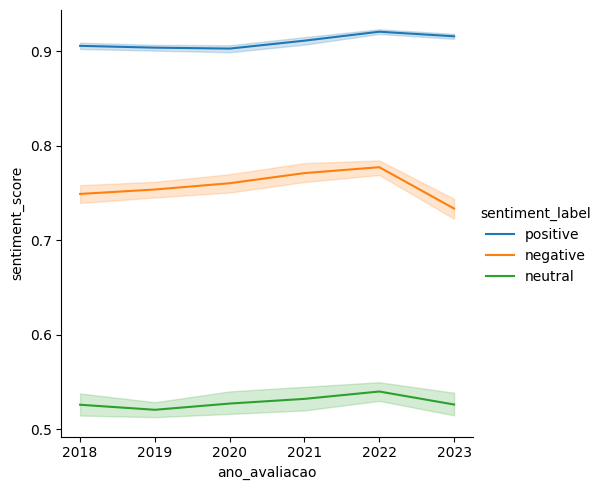

In [105]:
import seaborn as sns

sns.relplot(x='ano_avaliacao', y='sentiment_score', kind="line", hue='sentiment_label', data=teste)

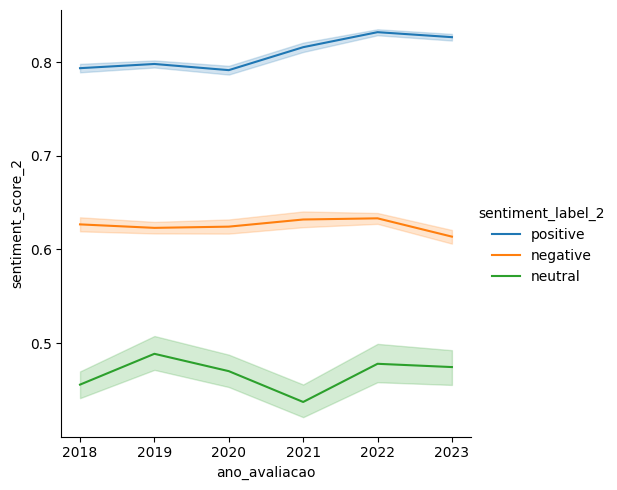

In [107]:
sns.relplot(x='ano_avaliacao', y='sentiment_score_2', kind="line", hue='sentiment_label_2', data=teste)

<Axes: xlabel='ano_avaliacao', ylabel='count'>

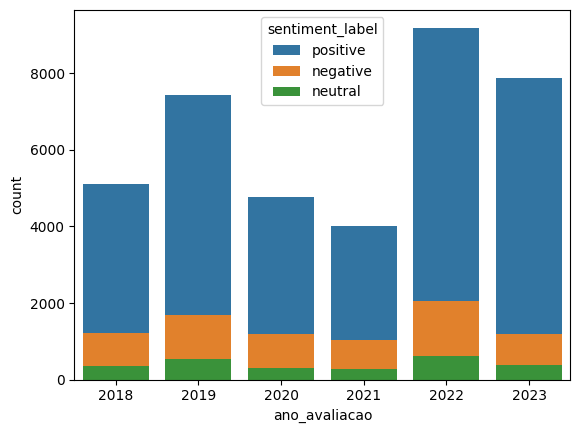

In [108]:
sns.countplot(x='ano_avaliacao',
              hue='sentiment_label',
              data=teste,
              dodge=False)

<Axes: xlabel='ano_avaliacao', ylabel='count'>

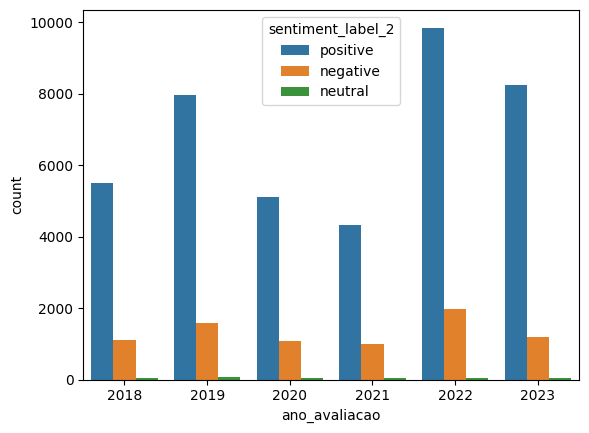

In [114]:
sns.countplot(x='ano_avaliacao',
              hue='sentiment_label_2',
              data=teste)

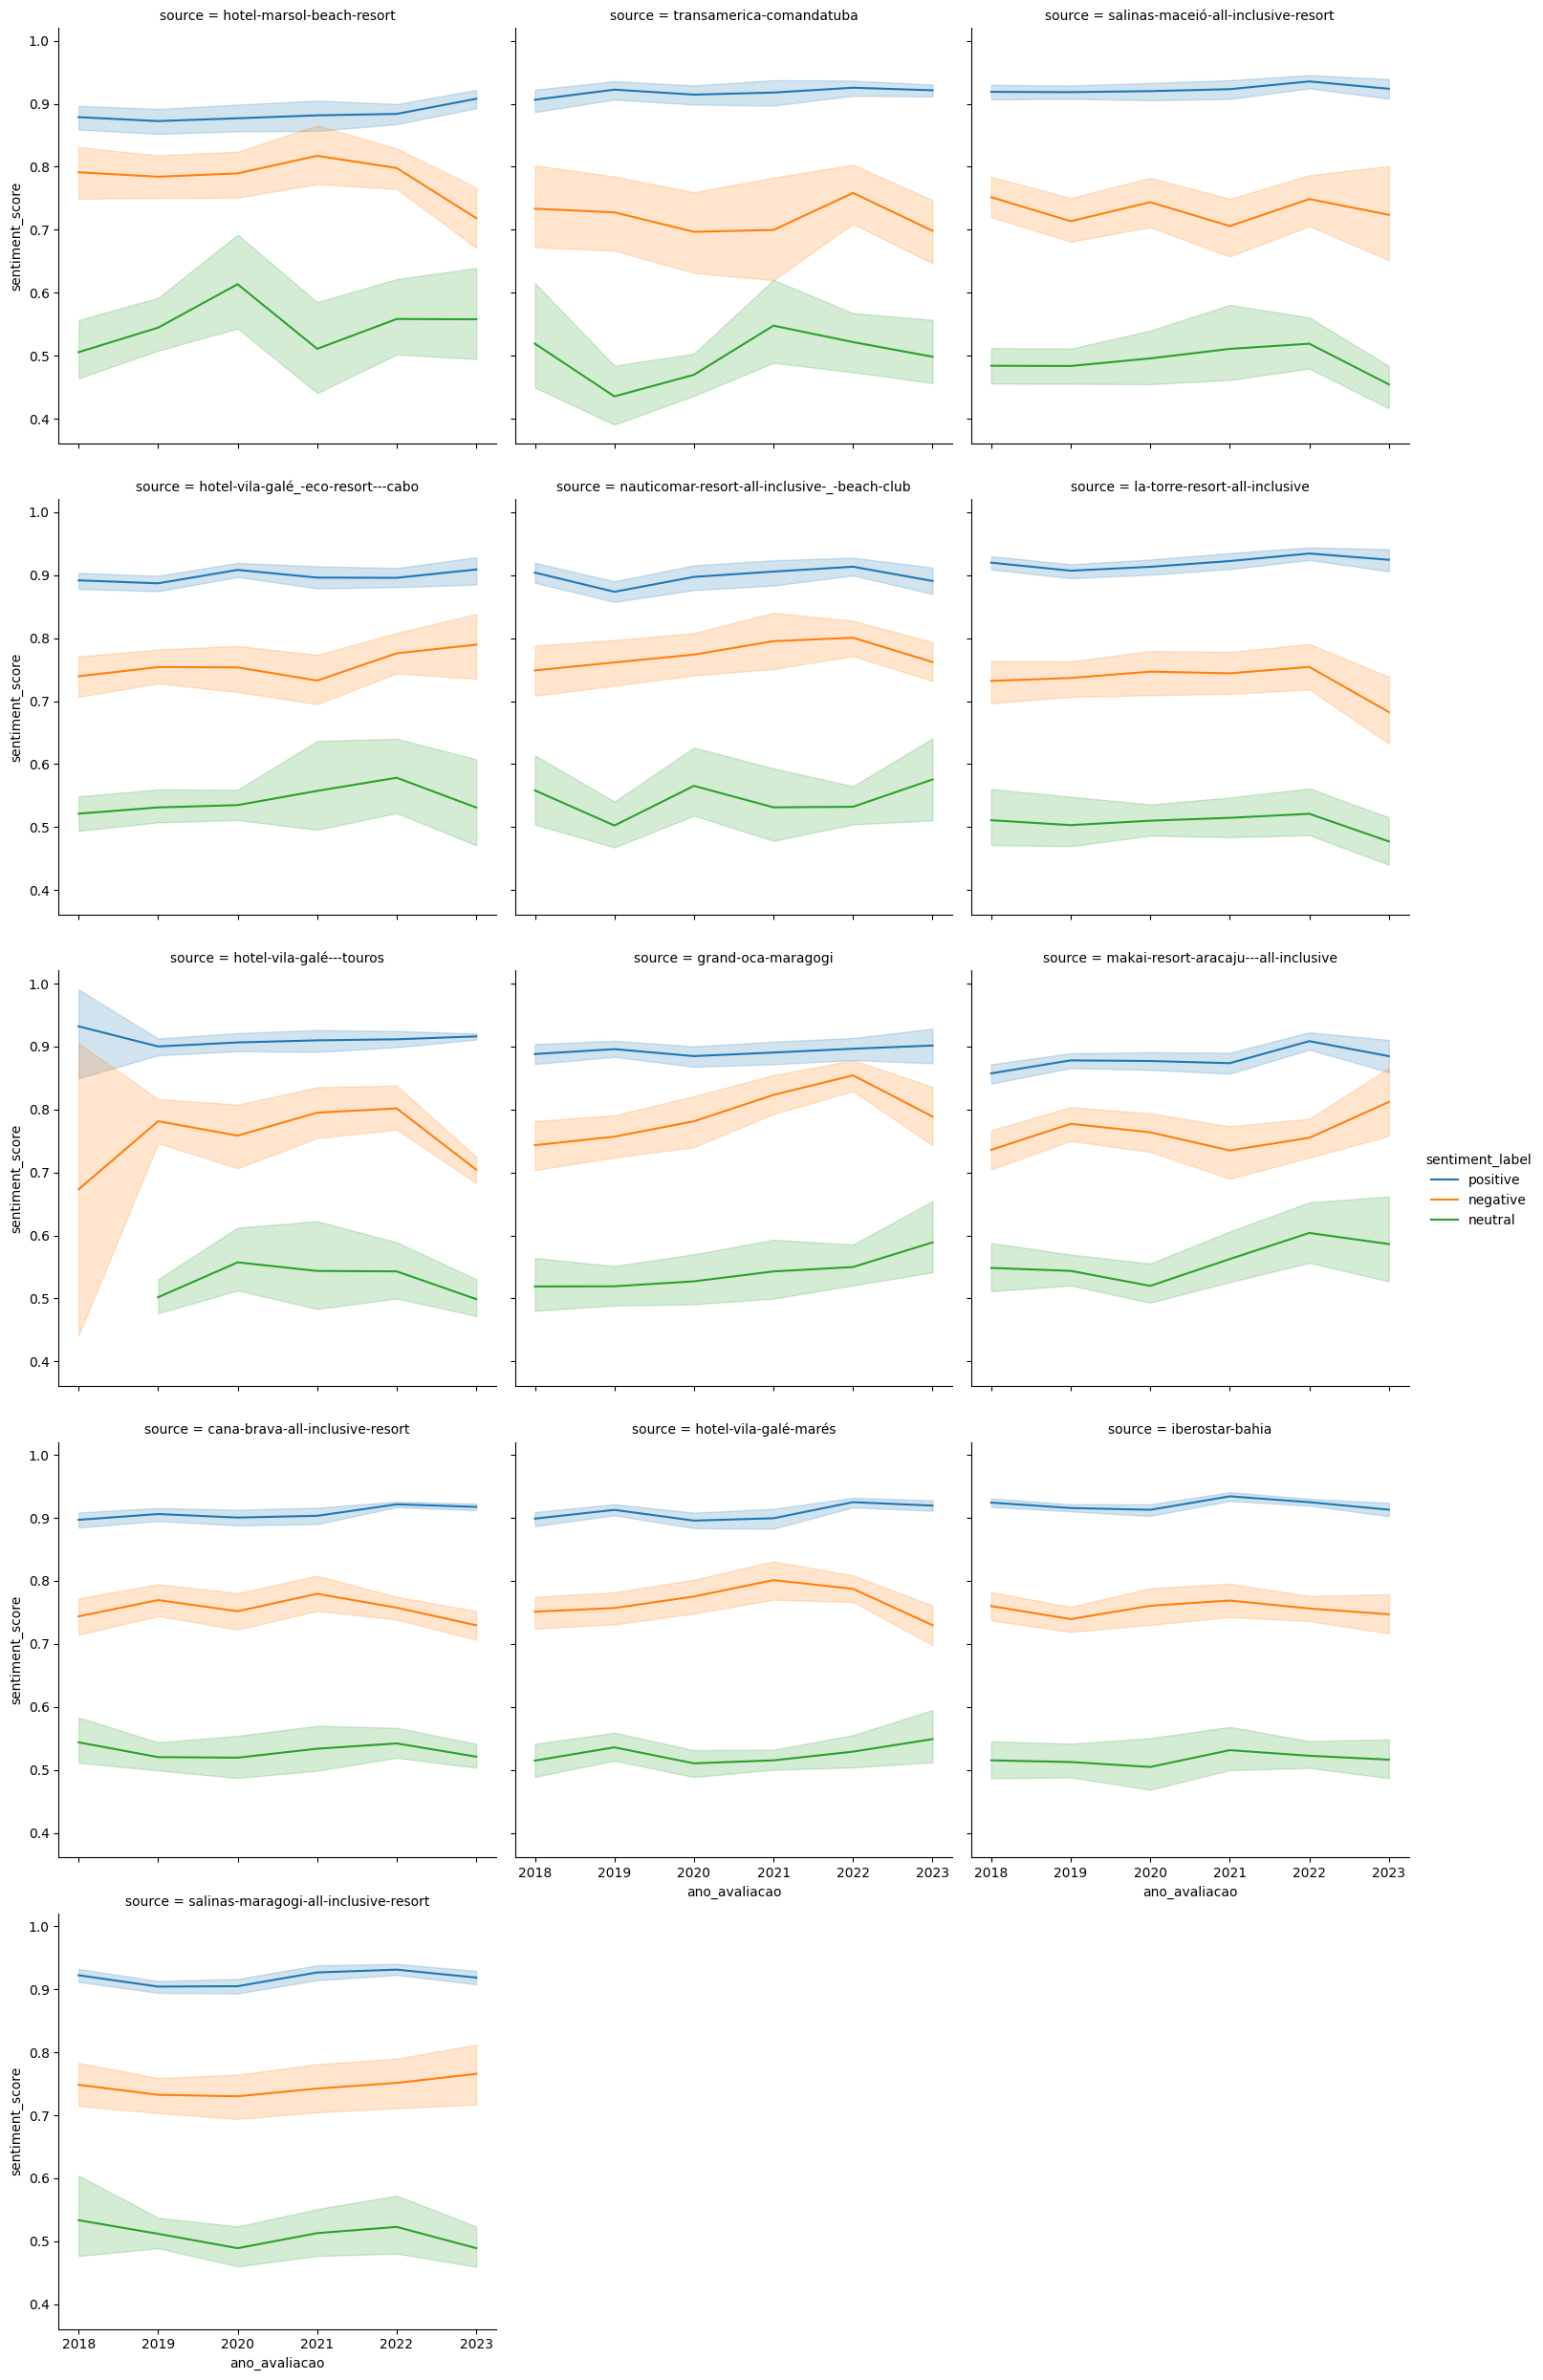

In [ ]:
sns.relplot(x='ano_avaliacao', col_wrap=3, col="source", y='sentiment_score', hue='sentiment_label', data=teste, kind='line')

In [138]:
teste[(teste.sentiment_label != teste.sentiment_label_2)][['text','sentiment_label','sentiment_label_2','sentiment_score','sentiment_score_2']]

,text,sentiment_label,sentiment_label_2,sentiment_score,sentiment_score_2
1,Tudo perfeito,positive,negative,0.970199,0.660210
17,"Quadra, piscina, praça e ao lado da praia sem ...",neutral,positive,0.512905,0.569789
19,É um ótimo hotel para levar a família e curtir...,positive,negative,0.957859,0.519933
20,"O hotel é limpo, os funcionários muito educado...",neutral,positive,0.725370,0.507336
28,"Aconchegante, bem localizado e com ótimo servi...",negative,positive,0.700109,0.746875
...,...,...,...,...,...
49183,O lugar ótimo para curtir as férias as piscina...,positive,negative,0.814663,0.726870
49191,Comida é excelente. Mas me decepcionei com as ...,negative,positive,0.538936,0.637641
49192,"ola, Estive agora em junho de 2017, de boa na...",positive,negative,0.594773,0.539711
49198,Muito bom! E nois aqui Alagoas,negative,positive,0.862629,0.874295


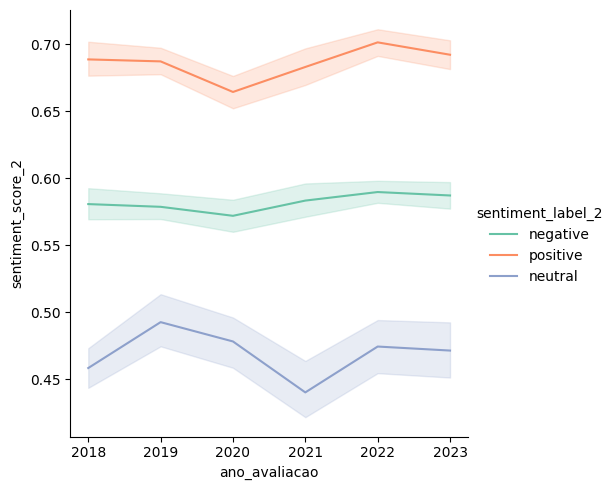

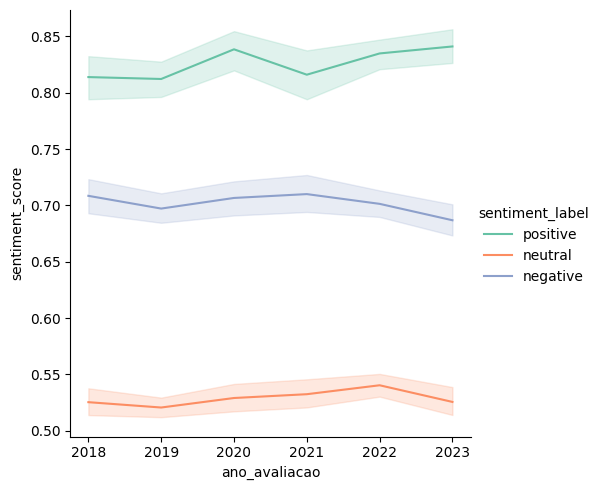

In [140]:
sns.relplot(x='ano_avaliacao', y='sentiment_score_2', kind="line", hue='sentiment_label_2', data=teste[(teste.sentiment_label != teste.sentiment_label_2)], palette='Set2')
sns.relplot(x='ano_avaliacao', y='sentiment_score', kind="line", hue='sentiment_label', data=teste[(teste.sentiment_label != teste.sentiment_label_2)], palette='Set2')

<Axes: xlabel='sentiment_score', ylabel='sentiment_score_2'>

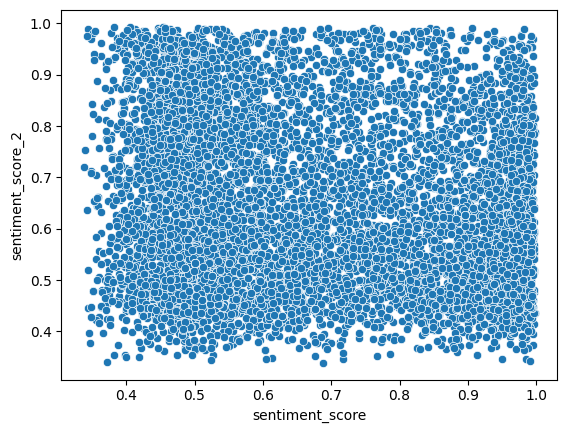

In [133]:
sns.scatterplot(data=teste[(teste.sentiment_label != teste.sentiment_label_2) & (abs(teste.sentiment_score - teste.sentiment_score_2) > 0.00)], x="sentiment_score", y="sentiment_score_2")

In [144]:
teste[(teste.sentiment_label != teste.sentiment_label_2) & (abs(teste.sentiment_score - teste.sentiment_score_2) > 0.00)].sample()

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,data_avaliacao,mes_avaliacao,...,nao_vazio,traduzido,depois_2017,analisar,sentiment_bert,sentiment_bert_2,sentiment_label,sentiment_score,sentiment_label_2,sentiment_score_2
14946,2023-07-07 00:35:06.679911,5.0,3 semanas atrás,0,False,"Estou deslumbrado com a beleza ,ao entorno do ...",hotel-vila-galé---touros,11,2023-06-16,6,...,True,False,True,True,"{'label': 'positive', 'score': 0.9673091173171...","{'label': 'negative', 'score': 0.7474360466003...",positive,0.967309,negative,0.747436


# bert

https://medium.com/data-hackers/an%C3%A1lise-de-sentimentos-em-portugu%C3%AAs-utilizando-pytorch-e-python-91a232165ec0

https://sol.sbc.org.br/index.php/stil/article/view/17784

https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

In [ ]:
import transformers
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, pipeline

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

PRE_TRAINED_MODEL_NAME = 'philschmid/distilbert-base-multilingual-cased-sentiment'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME).to(device)

In [ ]:
nlp = pipeline('sentiment-analysis',
               model=model,
               tokenizer=tokenizer,
               max_length=512,
               truncation=True,
               padding='max_length',
               pad_to_max_length=True,
               device=device,
               framework='pt',
               batch_size=16,
)

In [ ]:
nlp("Meu cachorro é muito top")

[{'label': 'positive', 'score': 0.9314833879470825}]

In [ ]:
classifications = [model.config.id2label[output] for output in range(len(model.config.id2label))]
print(classifications)

['negative', 'neutral', 'positive']


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import numpy as np

input_ids = tokenizer("Olá, meu cachorro é uma gracinha", return_tensors="pt", add_special_tokens=True).to(device)  # Batch size 1
outputs = model(**input_ids).logits

classifications = torch.argmax(outputs, axis=1)
print(classifications)

tensor([2], device='cuda:0')


In [ ]:
classifications.item()

2

In [ ]:
classifications = model.config.id2label[classifications.item()]
print(classifications)

positive


In [ ]:
outputs

tensor([[-0.3225,  0.1047,  0.2098]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
ax= sns.countplot(x=df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
%mkdir -p gdrive/MyDrive/tcc/bert
file_csv_data = 'gdrive/MyDrive/tcc/bert/reviews.csv'
df.to_csv(file_csv_data, index=None, header=True)

In [ ]:
sample_txt = df.loc[1]['text']
sample_txt

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

NameError: ignored

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=45,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

In [ ]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

In [ ]:
# deprecated sns.distplot(token_lens)
sns.histplot(token_lens,
             kde=True,
             stat="density",
             kde_kws=dict(cut=3),
             alpha=.4,
             edgecolor=(1, 1, 1, .4),
             )
plt.xlim([0, 600]);
plt.xlabel('Token count');

In [ ]:
max(token_lens)

In [ ]:
MAX_LEN = 512

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #padding='longest',
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
len(train_data_loader)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [ ]:
class SentimentClassifier(torch.nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = torch.nn.Dropout(p=0.3)
    #The last_hidden_state is a sequence of hidden states of the last layer of the model
    self.out = torch.nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)


In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

In [ ]:
history

In [ ]:
history['train_acc']

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)